<div style="padding: 15px; border: 1px solid #d4edda; background-color: #d4edda; color: #155724; border-radius: 5px; font-size: 30px;">

  <strong>EDA + Pre-Processing </strong>
</div>



# **1.** **Imports**

In [1]:
#!pip install ftfy
#!pip install emoji

In [2]:
#nltk.download('punkt')
#nltk.download('punkt_tab')
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('stopwords')
#nltk.download('wordnet')
from sklearn.model_selection import train_test_split
from utils import *

# **2.** **Data**

In [3]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [4]:
train_df.head()

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [5]:
train_df.shape #9543 rows, 2 columns

(9543, 2)

In [6]:
train_df.dtypes

text     object
label     int64
dtype: object

<span style="background-color: lightblue"> Everything seems ok with the data types </span>

# **3.** **Exploratory Analysis**

## **3.1** Label (Dependent feature)

In [7]:
train_df['label'].unique()

array([0, 1, 2])

<span style="background-color: lightblue"> We have 3 labels: 0, 1 and 2. They represent a Bearish (0), Bullish (1), or Neutral (2) attitude. </span>


In [8]:
train_df['label'].describe()

count    9543.000000
mean        1.496280
std         0.743139
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         2.000000
Name: label, dtype: float64

In [9]:
train_df['label'].value_counts()

label
2    6178
1    1923
0    1442
Name: count, dtype: int64

In [10]:
train_df['label'].value_counts(normalize=True)

label
2    0.647386
1    0.201509
0    0.151106
Name: proportion, dtype: float64

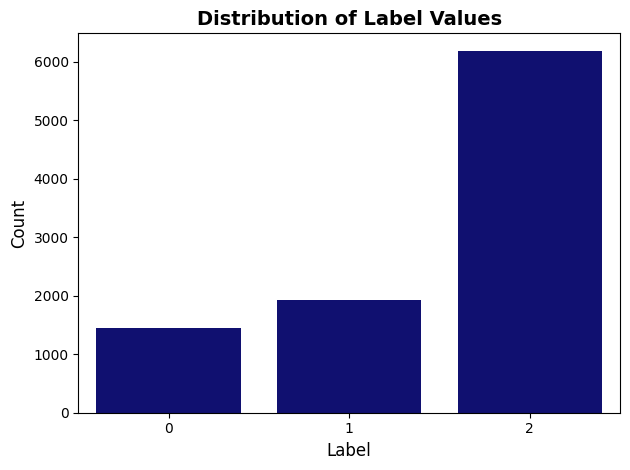

In [11]:
# Visualizing the distribution of the label values
sns.countplot(data=train_df, x='label', color='navy')
plt.title("Distribution of Label Values", fontsize=14, weight='bold')
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

 <span style="background-color: lightblue"> **Note:** Data Imbalance - Label 2 has almost 6 times more observations than the other 2 labels, it represents around 65% of the dataset. The Neutral attitude is the most predominant. This imbalance could bias the classifier towards predicting the dominant class. <span>

In [12]:
train_df['label'].isna().sum() #no missing values

0

## **3.2** Text (Independent features)

### **3.2.1** Coherence Check

In [13]:
#Checking a random text
train_df['text'][20]

'$NCBS: Hovde Group cuts to Market Perform'

In [14]:
train_df['text'].isna().sum() #no missing values

0

In [15]:
train_df['text'].duplicated().sum() #no duplicates

0

In [16]:
train_df['label'].unique()

array([0, 1, 2])

### **3.2.2** Word Count

In [17]:
train_df['word_count']  = train_df['text'].apply(lambda x: len(str(x).split(" ")))
train_df[['text','word_count']].head()

,text,word_count
0,$BYND - JPMorgan reels in expectations on Beyo...,10
1,$CCL $RCL - Nomura points to bookings weakness...,14
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",14
3,$ESS: BTIG Research cuts to Neutral https://t....,7
4,$FNKO - Funko slides after Piper Jaffray PT cu...,10


#### **3.2.2.1** Descriptive Statistics of word count

In [18]:
train_df.word_count.describe()

count    9543.000000
mean       12.168081
std         4.651245
min         1.000000
25%         9.000000
50%        11.000000
75%        15.000000
max        31.000000
Name: word_count, dtype: float64

<span style="background-color: lightblue">  On average, each tweet contains approximately 12 words, with 75% of them having 15 words or fewer. The maximum tweet length is 31 words, which falls within a reasonable range for Twitter data.
However, a noteworthy observation is the presence of very short tweets, with some containing as few as 1 word. These outliers may lack sufficient context for reliable sentiment prediction and could introduce noise into the model. It may be worth considering their removal or separate treatment during preprocessing. <span>

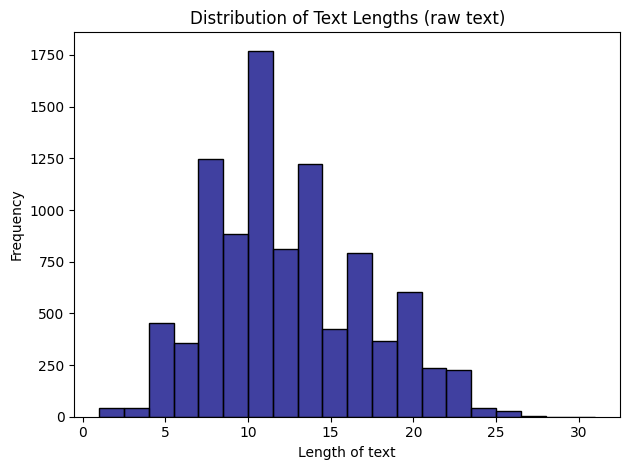

In [19]:
#Plot distribution of text length
sns.histplot(data=train_df['word_count'], bins=20, color='navy')
plt.title("Distribution of Text Lengths (raw text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [20]:
all_words = ' '.join(train_df['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

to     2332
the    1820
of     1464
-      1390
in     1361
on     1136
for    1032
a       970
and     898
The     663
Name: count, dtype: int64

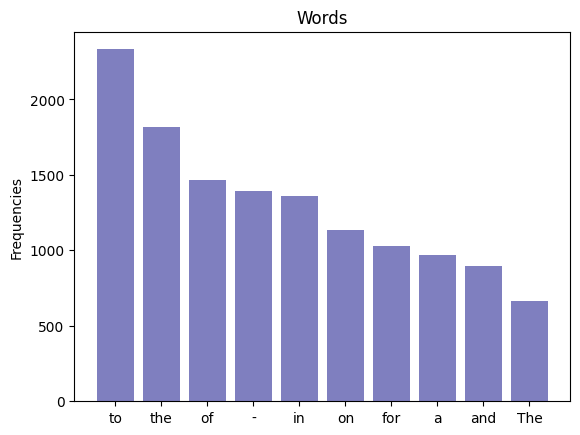

In [21]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5, color='navy')
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=0)
plt.show()

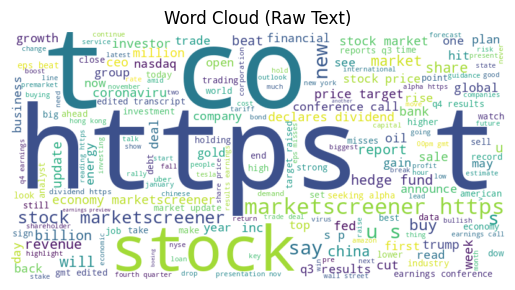

In [22]:
# Create a word cloud from the raw text
raw_text = ' '.join(train_df['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

In [23]:
# Calculating the top words by class
word_freq = get_top_words_by_class(train_df, 'label', 'text', top_criteria=25)
label_map = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
word_freq['label_name'] = word_freq['label'].map(label_map)

fig = px.treemap(word_freq, path=['label_name', 'word'], values='freq',
                 color='label_name', color_discrete_sequence=px.colors.qualitative.Set3)
fig.update_layout(title='Treemap of Frequent Words per Label')
fig.show()

<span style="background-color: lightblue"> We cannot draw insights that are useful since the text is still full of stop words. We will repeat this analysis later on. <span>

### **3.2.3** Encoding Problems Check

In [24]:
#checking the existence of encoding problems
encoding_issues = train_df.apply(lambda row: row.astype(str).str.contains(r'[�Ã©Ã£ÃªÃ¢Ã¡Ã³Ã§]').any(), axis=1)
train_df[encoding_issues]

,text,label,word_count
715,The stricken Bank of Jinzhou will unload $21 b...,2,23
2385,ItaÃƒÂº Unibanco S A : Payment of Dividends an...,2,17
2560,$MGDDF - Compagnie GÃƒÂ©nÃƒÂ©rale des Ãƒâ€°tab...,2,11
3879,�� Here's why one great whale offers more in t...,2,19
3880,�� Here's why Trump Tower is now one of the le...,2,16
5153,The £3bn hole in the Tory manifesto https://t....,2,8
5270,'There is more to Europe than the EU.' On #Bre...,2,20
5271,'There is more to Europe than the EU.' On #Bre...,2,20
5526,��Yes! We have no bananas.🎶 Watch the full vid...,2,19
5544,��🌍🌏Wind speeds are up globally. That's good n...,2,12


**Preprocessing step:** We need to handle encoding problems

In [25]:
#checking the existence of emojis
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # Codes that identify specific types of emojis
    u"\U0001F300-\U0001F5FF" 
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002700-\U000027BF"  
    u"\U0001F900-\U0001F9FF"  
    u"\U00002600-\U000026FF"  
    "]+", flags=re.UNICODE
)

# Filter rows with emojis
rows_with_emojis = train_df[train_df['text'].apply(lambda x: bool(emoji_pattern.search(str(x))))]

print(rows_with_emojis.head(10))

                                                   text  label  word_count
451   eib: #MustRead➡️EIB Bank Lending #Survey for #...      2          16
1388  Costco is selling special avocados that stay r...      2          20
3812  ⚡️ Wind speeds are up globally. That's good ne...      1          13
3972  ☀️ Cranberry farmers turn to solar power for e...      2          11
3973  ❄@GitHub is storing open source code in an Arc...      2          18
3974  ⚡️ @sussexuni scientists have developed hologr...      2          18
3975  ⚡️ Iman, the last Sumatran rhinoceros in Malay...      2          17
3976  ⚡️ Today is the International Day for the Elim...      2          20
3993  3 key pillars to ensure school infrastructure ...      2          16
4700  If your iPhone updated to the latest iOS, you ...      2          18


**Preprocessing step:** We need to remove emojis

# **4.** **Train-Test split**

In [26]:
x_train, x_val, y_train, y_val = train_test_split(train_df['text'], train_df['label'], test_size=0.20, random_state=42, stratify=train_df['label'])

In [27]:
len(x_train), len(x_val), len(y_train), len(y_val)

(7634, 1909, 7634, 1909)

In [ ]:
x_train

2186            Nasdaq prices 600M of 0.875% senior notes
6819                   Futures up https://t.co/diz7v5lmVb
6157    $ECONX: November Nonfarm Private Payrolls 125K...
2462    Twitter users explain why Kohl's stock just go...
4097    Agilysys : Restaurants Find Sustainable Method...
                              ...                        
2807                     Japan Tobacco reports FY results
704     The Fed's Emergence as a Power Player Poses Ne...
990     How the Rise of At-Home Fitness Services Could...
4362          Daniel Loeb's Top 5 Buys in the 3rd Quarter
7664    Zee Entertainment’s Subhash Chandra Resigns As...
Name: text, Length: 7634, dtype: object

**Note:** After the split, the train dataset has `7634 rows` and the validation dataset has `1909 rows`

# **5. Preprocessing**

In [29]:
x_train_cleaned = clean_text(x_train, lemmatize = True, stem = False)
x_val_cleaned = clean_text(x_val, lemmatize = True, stem = False)

100%|██████████| 1909/1909 [00:00<00:00, 9961.64it/s]


In [30]:
#Comparing before and after the cleaning
for i, text in enumerate(x_train):
    if "earnings" in text.lower():
        print(f"\nIndex: {i}")
        print("Before cleaning:", text)
        print("After cleaning:", x_train_cleaned[i])


Index: 3
Before cleaning: Twitter users explain why Kohl's stock just got obliterated after reporting earnings https://t.co/RnxmSz4Au1 by… https://t.co/F7B1rYCmPf
After cleaning: twitter user explain kohl stock got obliterated reporting earnings

Index: 8
Before cleaning: Manchester United Plc Announces Second Quarter Fiscal 2020 Earnings Report Date
After cleaning: manchester united plc announces second quarter fiscal earnings report date

Index: 18
Before cleaning: Top Earnings Mon 11/25 Aft: $A $AMBA $ARWR $BECN $CAL $HPE $MNR $MTSC $NAT $NTNX $PANW $PVH $SR
After cleaning: top earnings mon aft TICKER_a TICKER_amba TICKER_arwr TICKER_becn TICKER_cal TICKER_hpe TICKER_mnr TICKER_mtsc TICKER_nat TICKER_ntnx TICKER_panw TICKER_pvh TICKER_sr

Index: 58
Before cleaning: Edited Transcript of NANO.OL earnings conference call or presentation 19-Nov-19 7:30am GMT
After cleaning: edited transcript nano ol earnings conference call presentation nov gmt

Index: 67
Before cleaning: Earnings Upda

In [31]:
x_train_cleaned_df = pd.DataFrame(x_train_cleaned, columns=['text'], index=x_train.index) #convert the list to a Dataframe

In [32]:
x_train.shape #checking the number of rows originally

(7634,)

In [33]:
x_train_cleaned_df.shape #checking the number of rows after cleaning, no row was completely eliminated

(7634, 1)

**Note:** `Lemmatize` was chosen because stemming may produce words that do not exist and is less accurate

In [34]:
x_train_cleaned_df.head()

,text
2186,nasdaq price percent percent senior note
6819,future up
6157,november nonfarm private payroll k v k consens...
2462,twitter user explain kohl stock got obliterate...
4097,agilysys restaurant find sustainable method li...


In [48]:
train_cleaned_df = pd.DataFrame({
    'text': x_train_cleaned,
    'label': y_train
}, index=x_train.index)

# **6.** **Exploratory Analysis w/ clean data**

## **6.1** Word Count in the cleaned dataset

In [35]:
x_train_cleaned_df['word_count']  = x_train_cleaned_df['text'].apply(lambda x: len(str(x).split(" ")))
x_train_cleaned_df[['text','word_count']].head()

,text,word_count
2186,nasdaq price percent percent senior note,6
6819,future up,2
6157,november nonfarm private payroll k v k consens...,9
2462,twitter user explain kohl stock got obliterate...,9
4097,agilysys restaurant find sustainable method li...,11


### **6.1.1** Descriptive Statistics of word count

In [36]:
x_train_cleaned_df.word_count.describe()

count    7634.000000
mean        8.724653
std         2.928047
min         1.000000
25%         7.000000
50%         9.000000
75%        11.000000
max        30.000000
Name: word_count, dtype: float64

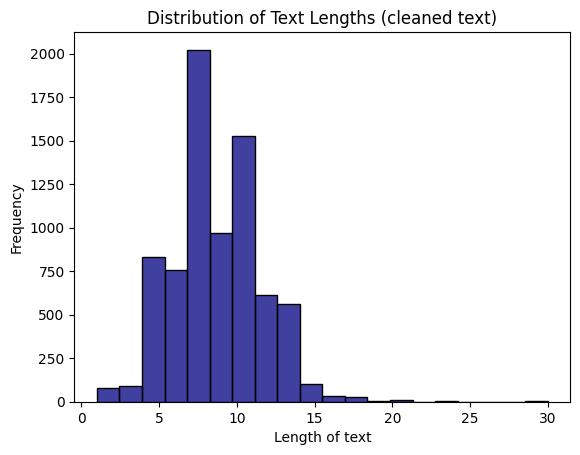

In [37]:
#Plot distribution of text length
sns.histplot(x_train_cleaned_df['word_count'], bins=20, color='navy')
plt.title("Distribution of Text Lengths (cleaned text)")
plt.xlabel("Length of text")
plt.ylabel("Frequency")
plt.show()

<span style="background-color: lightblue">  The lenght of the text in tweets decreased after the pre-processing from an average of 12 words per tweet to 8 words per tweet. We continue to have tweets that have a single word. We still have some long tweets. <span>

In [38]:
x_train_cleaned_df[x_train_cleaned_df.word_count>15]

,text,word_count
342,upgrade TICKER_arwr TICKER_caci TICKER_cf TICK...,24
2903,top earnings mon aft TICKER_a TICKER_amba TICK...,17
9406,ross store up nearly percent percent pace larg...,16
3436,dave buster report earnings total revenue incr...,16
8515,dragonfly capital premium top equal weighted g...,17
...,...,...
3561,motorcar part america report quarter eps v p c...,19
7938,updated chart u guy bullish macd crossover hou...,19
6377,october consumer credit up percent percent rev...,17
3609,penn national gaming report fourth quarter rev...,21


In [39]:
all_words = ' '.join(x_train_cleaned_df['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

percent           1439
stock             1077
market             464
quarter            463
up                 412
USA                410
marketscreener     404
report             335
price              325
new                316
Name: count, dtype: int64

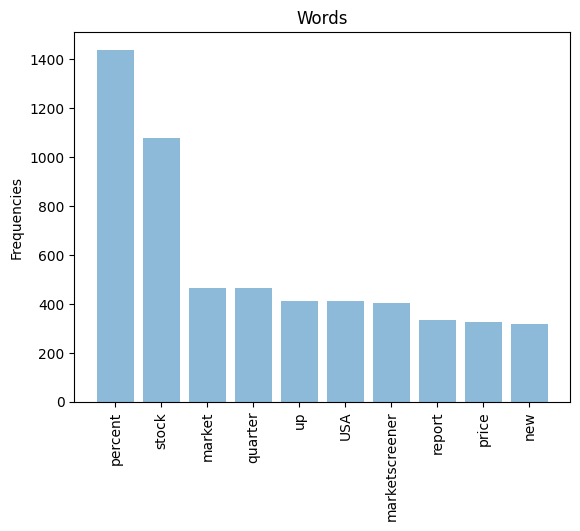

In [40]:
x_labels = freq.index[0:10]
values = freq[:10]
plt.bar(x_labels, values, align='center', alpha=0.5)
plt.xticks(x_labels)
plt.ylabel('Frequencies')
plt.title('Words')
plt.xticks(rotation=90)
plt.show()

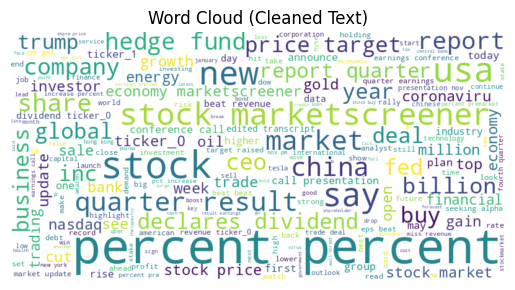

In [41]:
# Create a word cloud from the cleaned text
cleaned_text = ' '.join(x_train_cleaned_df['text'].fillna('')).lower()
cleaned_wc = WordCloud(width=800, height=400, background_color='white').generate(cleaned_text)
plt.imshow(cleaned_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Cleaned Text)')
plt.show()

In [47]:
x_train_cleaned_df

,text,word_count
2186,nasdaq price percent percent senior note,6
6819,future up,2
6157,november nonfarm private payroll k v k consens...,9
2462,twitter user explain kohl stock got obliterate...,9
4097,agilysys restaurant find sustainable method li...,11
...,...,...
2807,japan tobacco report fy result,5
704,fed emergence power player pose new risk indep...,10
990,rise home fitness service could benefit lulule...,8
4362,daniel loeb top buy rd quarter,6


In [49]:
# Calculating the top words by class
word_freq = get_top_words_by_class(train_cleaned_df, 'label', 'text', top_criteria=25)
label_map = {0: 'Bearish', 1: 'Bullish', 2: 'Neutral'}
word_freq['label_name'] = word_freq['label'].map(label_map)

fig = px.treemap(word_freq, path=['label_name', 'word'], values='freq',
                 color='label_name', color_discrete_sequence=px.colors.qualitative.Set3)
fig.update_layout(title='Treemap of Frequent Words per Label')
fig.show()